# Impact analysis of COVID lockdowns on Airbnb Listings in Los Angeles
#### Author: Nandini Hegde
<h2 align="center">Part 1- Calendar/Bookings dataset</h2>


This project is part of the submission for UDACITY CRISP-DM Project.
The article explaining the project is available at <a href="https://medium.com/@hegdenandini/impact-analysis-of-covid-lockdowns-on-airbnb-listings-in-los-angeles-19597b8cf6ac">this link</a>

The aim of is this analysis is to assess the Bookings trend and impact on airbnb bookings/sales during the covid lockdowns announced in early 2020 in comparison to the trends found during the same months in 2019

In this part of the analysis we will be **focused on the calendar dataset**. Part 2 of the analysis is focused on analysisng the listing and calendar datasets together

### 1.0 Analysis Setup
Setting up libraries, reusable functions before we start the analysis.

**Importing required libraries**

In [1]:

import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import re
import locale
import matplotlib.dates as mdates
import numpy as np
import matplotlib.cbook as cbook
import calendar
import datetime

# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer

#Google cloud connectivity
import gcsfs
from google.cloud import storage
from IPython.core.display import display
import pandas_gbq

#import collections
from dask_ml.impute import SimpleImputer
import category_encoders as ce

#garbage collector to free memory
import gc

#library for saving models
import pickle
#print parameters
from pprint import pprint

**Frequently used functions**

In [2]:
#function to print large dataframe in limited space
def display_(df):     
    pd.set_option("display.max_rows", None)          
    display(df)
    
    
#function to reduce memory usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

### 1.1 Data Reading and Cleaning of calendar(bookings) datasets

In [3]:
"""We have Airbnb listing and calendar bookings datasets which were scraped from the website from Jan 
to June both 2019 and 2020 for comparison
With each new month we can compare the changes in bookings/cancellations made on a particular date """

#Read the calendar datasets alone first for EDA
#list of years and months when data was scraped

years=['2019','2020']
month_datascraped= ['Jan','Feb','March','April','May','June']

#empty lists
calendar_2019={}
calendar_2020={}

#reading the datasets one at a time
for year in years:
    for month in month_datascraped:
        filename=month+year
        print("Parsing dataset: "+ filename)
        if '2019' in year:
            url='gs://airbnblosangeles/Los Angeles_gcloud/Datasets_'+year+'/'+month+year+'/calendar.csv'
            temp_df=pd.read_csv(url)
            temp_df=reduce_mem_usage(temp_df)
            calendar_2019[filename]=temp_df
            calendar_2019[filename]['month_datascraped']=filename
        else:
            url='gs://airbnblosangeles/Los Angeles_gcloud/Datasets_'+year+'/'+month+year+'/calendar.csv'
            temp_df=pd.read_csv(url)
            temp_df=reduce_mem_usage(temp_df)
            calendar_2020[filename]=temp_df
            calendar_2020[filename]['month_datascraped']=filename


Parsing dataset: Jan2019
Memory usage of dataframe is 845.86 MB
Memory usage after optimization is: 257.19 MB
Decreased by 69.6%
Parsing dataset: Feb2019
Memory usage of dataframe is 852.28 MB
Memory usage after optimization is: 259.13 MB
Decreased by 69.6%
Parsing dataset: March2019
Memory usage of dataframe is 842.03 MB
Memory usage after optimization is: 256.01 MB
Decreased by 69.6%
Parsing dataset: April2019
Memory usage of dataframe is 846.79 MB
Memory usage after optimization is: 257.46 MB
Decreased by 69.6%
Parsing dataset: May2019
Memory usage of dataframe is 856.81 MB
Memory usage after optimization is: 260.50 MB
Decreased by 69.6%
Parsing dataset: June2019
Memory usage of dataframe is 868.07 MB
Memory usage after optimization is: 263.92 MB
Decreased by 69.6%
Parsing dataset: Jan2020
Memory usage of dataframe is 769.74 MB
Memory usage after optimization is: 234.05 MB
Decreased by 69.6%
Parsing dataset: Feb2020
Memory usage of dataframe is 757.33 MB
Memory usage after optimizat

In [4]:
#check if all 6 datsets loaded
print('2019 files loaded:'+str(len(calendar_2019)))
print('2020 files loaded:'+str(len(calendar_2020)))

2019 files loaded:6
2020 files loaded:6


In [6]:
# Concat all the datasets for analysis
calendar2019_df=pd.concat(calendar_2019)
calendar2020_df=pd.concat(calendar_2020)
calendar2019_df.head()

listing_id        date available    price adjusted_price  \
Jan2019 0        2732  2019-01-12         t  $140.00        $140.00   
        1        2732  2019-01-13         t  $140.00        $140.00   
        2        2732  2019-01-14         t  $140.00        $140.00   
        3        2732  2019-01-15         t  $140.00        $140.00   
        4        2732  2019-01-16         t  $140.00        $140.00   

           minimum_nights  maximum_nights month_datascraped  
Jan2019 0             1.0           180.0           Jan2019  
        1             1.0           180.0           Jan2019  
        2             1.0           180.0           Jan2019  
        3             1.0           180.0           Jan2019  
        4             1.0           180.0           Jan2019

In [7]:
#release memory by deleting the contated lists
del calendar_2019
del calendar_2020
gc.collect()

40

In [8]:
#check memory usage
calendar2019_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 95717084 entries, ('Jan2019', 0) to ('June2019', 16254323)
Data columns (total 8 columns):
 #   Column             Dtype   
---  ------             -----   
 0   listing_id         int32   
 1   date               object  
 2   available          category
 3   price              object  
 4   adjusted_price     object  
 5   minimum_nights     float16 
 6   maximum_nights     float32 
 7   month_datascraped  object  
dtypes: category(1), float16(1), float32(1), int32(1), object(4)
memory usage: 4.4+ GB


In [9]:
#release memory by deleting columns that are not useful for current analysis
del calendar2019_df['adjusted_price']
del calendar2019_df['minimum_nights']
del calendar2019_df['maximum_nights']
del calendar2020_df['adjusted_price']
del calendar2020_df['minimum_nights']
del calendar2020_df['maximum_nights']


In [10]:
#Remove special symbols from Price and drop columns that wont be used
calendar2019_df['price'] = calendar2019_df['price'].str.replace(r'[^\d.]', '').astype('float16')
calendar2020_df['price'] = calendar2020_df['price'].str.replace(r'[^\d.]', '').astype('float16')
calendar2019_df.head()

listing_id        date available  price month_datascraped
Jan2019 0        2732  2019-01-12         t  140.0           Jan2019
        1        2732  2019-01-13         t  140.0           Jan2019
        2        2732  2019-01-14         t  140.0           Jan2019
        3        2732  2019-01-15         t  140.0           Jan2019
        4        2732  2019-01-16         t  140.0           Jan2019

In [11]:
#check datatypes
calendar2019_df.dtypes

listing_id              int32
date                   object
available            category
price                 float16
month_datascraped      object
dtype: object

In [71]:
#Count missing data in 2020 dataset
calendar2020_df.isna().sum()

listing_id              0
date                    0
available               0
price                1447
month_datascraped       0
dtype: int64

In [12]:
#Count missing data in 2019 dataset
calendar2019_df.isna().sum()

listing_id              0
date                    0
available               0
price                1815
month_datascraped       0
dtype: int64

The missing data is related to price column only, since we wont be using either at this stage. I will reserve the imputation  to a later stage in Part 2

In [13]:
#Check distribution of numerical columns in 2019 dataset
pd.set_option('float_format', '{:f}'.format)
calendar2019_df.describe()

,listing_id,price
count,95717084.000000,95715269.000000
mean,19483820.243639,nan
std,9598699.152024,nan
min,109.000000,0.000000
25%,12523420.000000,72.000000
50%,20921244.000000,111.000000
75%,27753488.000000,193.000000
max,35374058.000000,29152.000000


In [14]:
#Check distribution of numerical columns in 2020 dataset
pd.set_option('float_format', '{:f}'.format)
calendar2020_df.describe()

,listing_id,price
count,82985242.000000,82983795.000000
mean,24815309.189964,nan
std,12554031.225889,nan
min,109.000000,0.000000
25%,15042665.000000,70.000000
50%,25872676.000000,110.000000
75%,36118289.000000,193.000000
max,43729698.000000,24992.000000


The max price seems to be a outlier, in the price distribution, a Box plot can help identify the distribution

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7f2c8ef190>]],
      dtype=object)

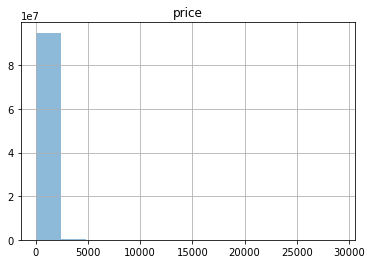

In [22]:
calendar2019_df.hist(column='price',bins=12, alpha=0.5)

In [37]:
calendar2019_df.loc[calendar2019_df['price'] >=25000]

listing_id        date available        price  \
April2019 14187298    31513218  2019-04-06         t 29152.000000   
          14187299    31513218  2019-04-07         t 29152.000000   
          14187300    31513218  2019-04-08         t 29152.000000   
          14187301    31513218  2019-04-09         t 29152.000000   
          14187302    31513218  2019-04-10         t 29152.000000   
...                        ...         ...       ...          ...   
          14187563    31513218  2019-12-27         t 29152.000000   
          14187564    31513218  2019-12-28         t 29152.000000   
          14187565    31513218  2019-12-29         t 29152.000000   
          14187566    31513218  2019-12-30         t 29152.000000   
          14187567    31513218  2019-12-31         t 29152.000000   

                   month_datascraped  
April2019 14187298         April2019  
          14187299         April2019  
          14187300         April2019  
          14187301         April2019  
          14187302         April2019  
...                              ...  
          14187563         April2019  
          14187564         April2019  
          14187565         April2019  
          14187566         April2019  
          14187567         April2019  

[270 rows x 5 columns]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7f2c7909d0>]],
      dtype=object)

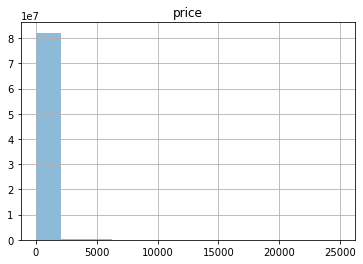

In [33]:
calendar2020_df.hist(column='price',bins=12, alpha=0.5)

In [39]:
calendar2020_df.loc[calendar2020_df['price'] >=20000].shape

(8134, 5)

Despite the outliers, there are several listings which are in the top 90 percentile range so we will leave them as is as they dont look like an error

### 1.2 Feature extraction from calendars dataset for analysis along with listings dataset in Part 2


In [40]:
#Extracting additional features from the calendars dataset 
calendar2019_df=calendar2019_df.reset_index(drop=True)
calendar2020_df=calendar2020_df.reset_index(drop=True)
calendar2019_df['date']=pd.to_datetime(calendar2019_df['date'])
calendar2020_df['date']=pd.to_datetime(calendar2020_df['date'])
calendar2019_df['month'] = calendar2019_df['date'].dt.month
calendar2020_df['month'] = calendar2020_df['date'].dt.month
calendar2019_df['year'] = calendar2019_df['date'].dt.year
calendar2020_df['year'] = calendar2020_df['date'].dt.year
calendar2019_df.head()

,listing_id,date,available,price,month_datascraped,month,year
0,2732,2019-01-12,t,140.000000,Jan2019,1,2019
1,2732,2019-01-13,t,140.000000,Jan2019,1,2019
2,2732,2019-01-14,t,140.000000,Jan2019,1,2019
3,2732,2019-01-15,t,140.000000,Jan2019,1,2019
4,2732,2019-01-16,t,140.000000,Jan2019,1,2019


**DATACHECKPOINT-Uploading calendar dataframes to BigQuery to enable efficient pivoting**

In [75]:
#Uploading transformaed calendar datasets to BigQuery for ease of access 
pandas_gbq.to_gbq(calendar2019_df, 'airbnbLA.calendar2019', project_id='udacity-crisp-dm-project',if_exists='fail')


1it [34:05, 2045.35s/it]


In [76]:
pandas_gbq.to_gbq(calendar2020_df, 'airbnbLA.calendar2020', project_id='udacity-crisp-dm-project',if_exists='fail')

1it [30:40, 1840.84s/it]


#### Ran pivot and join queries on Bigquery platform to save processing time 

- Querys to pivot on calendar dataset so it can be joined with the listing analysis are as below, results were saved booked_listing2019 and booked_listing2020 tables respectively
- Queries run on Bigquery are inline below

<blockquote>
Select 
listing_id,month_datascraped,year,month,day_of_week, COUNT(*) as future_bookings, avg(price) as Avgprice
from udacity-crisp-dm-project.airbnbLA.calendar2019
where available='f'
group by listing_id,month_datascraped,year,month,day_of_week
</blockquote>    

<blockquote>
Select 
listing_id,month_datascraped,year,month,day_of_week, COUNT(*) as future_bookings, avg(price) as Avgprice
from udacity-crisp-dm-project.airbnbLA.calendar2020
where available='f'
group by listing_id,month_datascraped,year,month,day_of_week
</blockquote>

- Querys to pivot on calendar dataset for further trend analysis in this notbook are as below, results were saved booked_listing2019 and booked_listing2020 tables respectively
- Queries run on Bigquery are inline below

<blockquote>
 Select CAST(date AS DATE) As date,
   COUNT(CASE WHEN month_datascraped='Jan2019' THEN listing_id ELSE NULL END) AS Jan2019,
   COUNT(CASE WHEN month_datascraped='Feb2019' THEN listing_id ELSE NULL END) AS Feb2019,
   COUNT(CASE WHEN month_datascraped='March2019' THEN listing_id ELSE NULL END) AS March2019,
   COUNT(CASE WHEN month_datascraped='April2019' THEN listing_id ELSE NULL END) AS April2019,
   COUNT(CASE WHEN month_datascraped='May2019' THEN listing_id ELSE NULL END) AS May2019,
   COUNT(CASE WHEN month_datascraped='June2019' THEN listing_id ELSE NULL END) AS June2019,
   SUM(CASE WHEN month_datascraped='Jan2019' THEN price ELSE NULL END) AS Jan2019_projsales,
   SUM(CASE WHEN month_datascraped='Feb2019' THEN listing_id ELSE NULL END) AS Feb2019_projsales,
   SUM(CASE WHEN month_datascraped='March2019' THEN listing_id ELSE NULL END) AS March2019_projsales,
   SUM(CASE WHEN month_datascraped='April2019' THEN listing_id ELSE NULL END) AS April2019_projsales,
   SUM(CASE WHEN month_datascraped='May2019' THEN listing_id ELSE NULL END) AS May2019_projsales,
   SUM(CASE WHEN month_datascraped='June2019' THEN listing_id ELSE NULL END) AS June2019_projsales,
   from udacity-crisp-dm-project.airbnbLA.calendar2019 
   where available='f' 
   group by date
   order by date
</blockquote>
  

<blockquote>
Select CAST(date AS DATE) As date,
   COUNT(CASE WHEN month_datascraped='Jan2020' THEN listing_id ELSE NULL END) AS Jan2020,
   COUNT(CASE WHEN month_datascraped='Feb2020' THEN listing_id ELSE NULL END) AS Feb2020,
   COUNT(CASE WHEN month_datascraped='March2020' THEN listing_id ELSE NULL END) AS March2020,
   COUNT(CASE WHEN month_datascraped='April2020' THEN listing_id ELSE NULL END) AS April2020,
   COUNT(CASE WHEN month_datascraped='May2020' THEN listing_id ELSE NULL END) AS May2020,
   COUNT(CASE WHEN month_datascraped='June2020' THEN listing_id ELSE NULL END) AS June2020,
   SUM(CASE WHEN month_datascraped='Jan2020' THEN price ELSE NULL END) AS Jan2020_projsales,
   SUM(CASE WHEN month_datascraped='Feb2020' THEN listing_id ELSE NULL END) AS Feb2020_projsales,
   SUM(CASE WHEN month_datascraped='March2020' THEN listing_id ELSE NULL END) AS March2020_projsales,
   SUM(CASE WHEN month_datascraped='April2020' THEN listing_id ELSE NULL END) AS April2020_projsales,
   SUM(CASE WHEN month_datascraped='May2020' THEN listing_id ELSE NULL END) AS May2020_projsales,
   SUM(CASE WHEN month_datascraped='June2020' THEN listing_id ELSE NULL END) AS June2020_projsales,
   from udacity-crisp-dm-project.airbnbLA.calendar2020 
   where available='f' 
   group by date
   order by date
</blockquote>


In [43]:
#Fetching the pivoted tables from BigQuery
sql = str("""SELECT * FROM udacity-crisp-dm-project.airbnbLA.calendar2019_Sales""")
calendar2019_Sales = pd.read_gbq(sql, use_bqstorage_api=True)
sql = str("""SELECT * FROM udacity-crisp-dm-project.airbnbLA.calendar2020_Sales""")
calendar2020_Sales = pd.read_gbq(sql, use_bqstorage_api=True)
calendar2020_Sales.head()

Downloading: 100%|██████████| 525/525 [00:01<00:00, 354.58rows/s]


,date,Jan2020,Feb2020,March2020,April2020,May2020,June2020,Jan2020_projsales,Feb2020_projsales,March2020_projsales,April2020_projsales,May2020_projsales,June2020_projsales
0,2020-01-04,21122,0,0,0,0,0,4446652.000000,nan,nan,nan,nan,nan
1,2020-01-05,26982,0,0,0,0,0,4960693.000000,nan,nan,nan,nan,nan
2,2020-01-06,24817,0,0,0,0,0,4114802.000000,nan,nan,nan,nan,nan
3,2020-01-07,24012,0,0,0,0,0,3856781.000000,nan,nan,nan,nan,nan
4,2020-01-08,23932,0,0,0,0,0,3837602.000000,nan,nan,nan,nan,nan


As is visible for the dataset above it makes sense that the data scraped on Feb 2020 has missing values for dates in January since it is a previous data and wont be available to scrape in Feb 2020 (similar for consecutive months)

### 1.3 Trend analysis of Bookings made(Calendar dataset) during the months of  Jan-June in 2019 vs 2020

In [44]:
#Split into multiple dataframes for visualisation
cal2019_df_unavl_pivoted=calendar2019_Sales[['date', 'Jan2019', 'Feb2019', 'March2019', 'April2019', 'May2019','June2019']]
cal2019_df_sales_pivoted=calendar2019_Sales[['date', 'Jan2019_projsales', 'Feb2019_projsales','March2019_projsales', 'April2019_projsales', 'May2019_projsales','June2019_projsales']]
cal2019_df_unavl_pivoted = cal2019_df_unavl_pivoted.set_index('date') 
cal2019_df_sales_pivoted = cal2019_df_sales_pivoted.set_index('date') 
cal2019_df_unavl_pivoted.replace(0, np.nan, inplace=True)
cal2020_df_unavl_pivoted=calendar2020_Sales[['date', 'Jan2020', 'Feb2020', 'March2020', 'April2020', 'May2020','June2020']]
cal2020_df_sales_pivoted=calendar2020_Sales[['date','Jan2020_projsales', 'Feb2020_projsales',
       'March2020_projsales', 'April2020_projsales', 'May2020_projsales',
       'June2020_projsales']]
cal2020_df_unavl_pivoted = cal2020_df_unavl_pivoted.set_index('date') 
cal2020_df_sales_pivoted = cal2020_df_sales_pivoted.set_index('date') 
cal2020_df_unavl_pivoted.replace(0, np.nan, inplace=True)
cal2019_df_unavl_pivoted.head()

,Jan2019,Feb2019,March2019,April2019,May2019,June2019
date,,,,,,
2019-01-11,12843.000000,nan,nan,nan,nan,nan
2019-01-12,31296.000000,nan,nan,nan,nan,nan
2019-01-13,27483.000000,nan,nan,nan,nan,nan
2019-01-14,25517.000000,nan,nan,nan,nan,nan
2019-01-15,25147.000000,nan,nan,nan,nan,nan


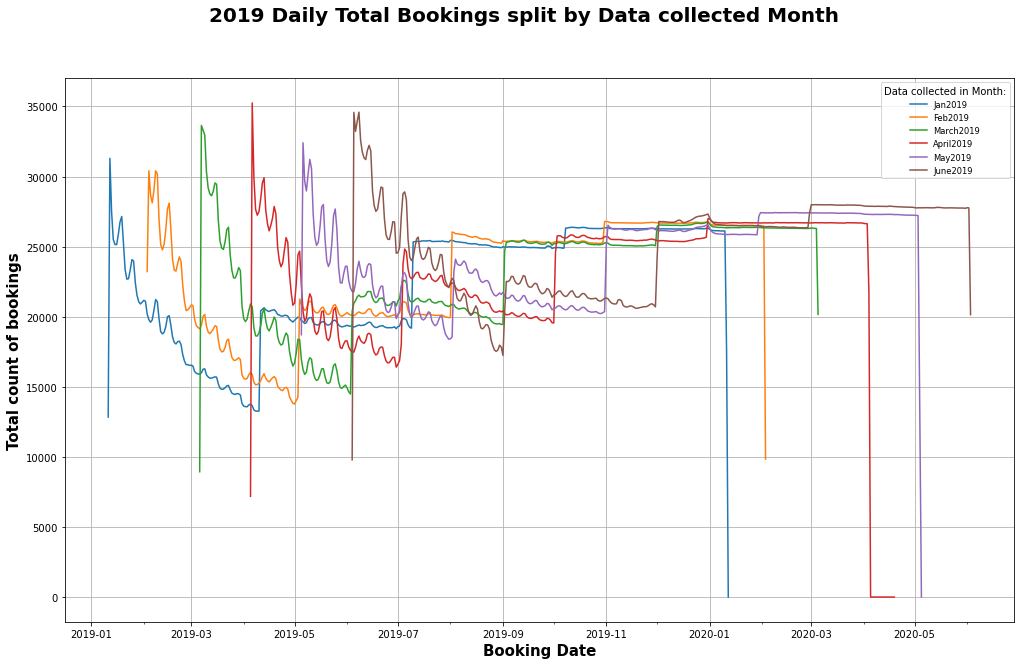

In [47]:
#Bookings Trend for 2019 datasets
years = mdates.AutoDateLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y-%m')

fig, ax = plt.subplots(figsize=(17,10))

plt.xlabel("Booking Date",fontsize =15,fontweight = 'bold')
plt.ylabel("Total count of bookings",fontsize =15,fontweight = 'bold')

#ax.plot('date', 'adj_close', data=data)
ax.plot(cal2019_df_unavl_pivoted.index, cal2019_df_unavl_pivoted.values)
fig.suptitle('2019 Daily Total Bookings split by Data collected Month',fontsize =20,fontweight = 'bold')
ax.legend(['Jan2019','Feb2019','March2019','April2019','May2019','June2019'],loc="upper right",title="Data collected in Month:", fontsize='small', fancybox=True)

# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)

# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.format_ydata = lambda x: '$%1.2f' % x  # format the bookings.
ax.grid(True)

plt.show()

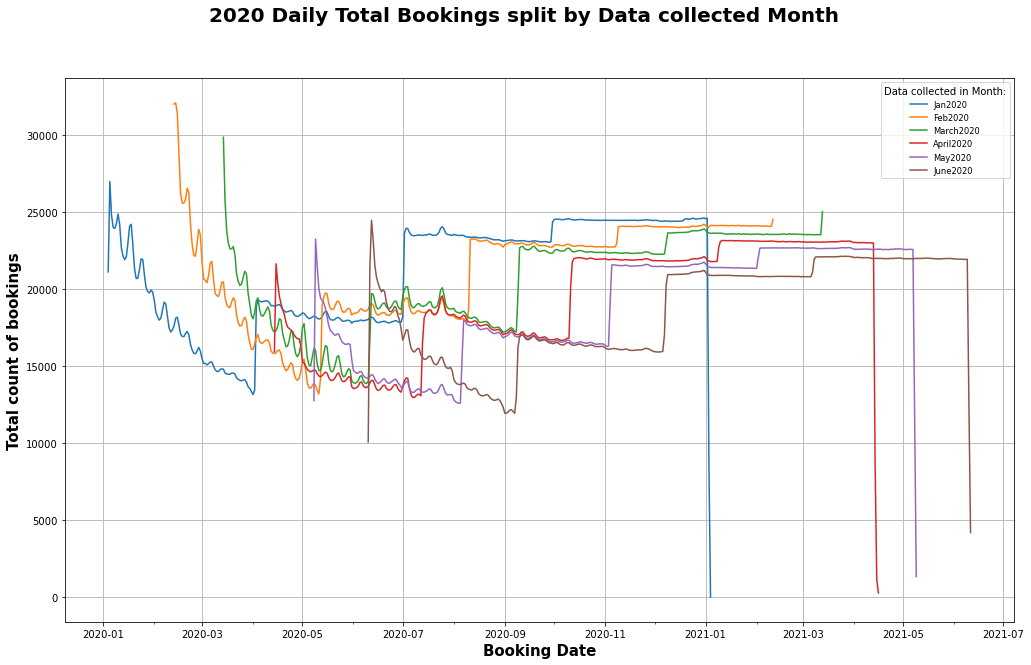

In [48]:
#Bookings Trend for 2020 datasets
cal2020_df_unavl_pivoted.index = pd.to_datetime(cal2020_df_unavl_pivoted.index)
fig, ax = plt.subplots(figsize=(17,10))

#ax.plot('date', 'adj_close', data=data)
ax.plot(cal2020_df_unavl_pivoted.index, cal2020_df_unavl_pivoted)
fig.suptitle('2020 Daily Total Bookings split by Data collected Month',fontsize =20,fontweight = 'bold')
ax.legend(['Jan2020','Feb2020','March2020','April2020','May2020','June2020'],loc="upper right",title="Data collected in Month:", fontsize='small', fancybox=True)

# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)

plt.xlabel("Booking Date",fontsize =15,fontweight = 'bold')
plt.ylabel("Total count of bookings",fontsize =15,fontweight = 'bold')

# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.format_ydata = lambda x: '$%1.2f' % x  # format the price.
ax.grid(True)

plt.show()

From the above trends it is clear that bookings were somewhat higher when data was collected closer to the booking date and it remained somewhat stable for future bookings. For the trend in 2020 it is clear that bookings clearly dropped/cancellations increased closer to the booking date.This is expecially consistent with the timeline of when lockdowns were announced in the state of california. In order to get a sense of the dip in bookings in covid era vs pre covid era. We can compare the average monthly bookings for the 2 years especially for the months that are common to all the datasets.

In [49]:
# Subset the dates which are available in all datasets
min_Date_2019=min(calendar2019_df[calendar2019_df['month_datascraped']=='June2019']['date'])
max_Date_2019 =max(calendar2019_df[calendar2019_df['month_datascraped']=='Jan2019']['date'])

min_Date_2020=min(calendar2020_df[calendar2020_df['month_datascraped']=='June2020']['date'])
max_Date_2020 =max(calendar2020_df[calendar2020_df['month_datascraped']=='Jan2020']['date'])


In [50]:
#Add month-year column to calculate avg by month-year
cal2019_df_unavl_pivoted['month_year'] = pd.to_datetime(cal2019_df_unavl_pivoted.index).to_period('M')
cal2020_df_unavl_pivoted['month_year'] = pd.to_datetime(cal2020_df_unavl_pivoted.index).to_period('M')
cal2019_df_sales_pivoted['month_year'] = pd.to_datetime(cal2019_df_sales_pivoted.index).to_period('M')
cal2020_df_sales_pivoted['month_year'] = pd.to_datetime(cal2020_df_sales_pivoted.index).to_period('M')
cal2020_df_unavl_pivoted.head()

,Jan2020,Feb2020,March2020,April2020,May2020,June2020,month_year
date,,,,,,,
2020-01-04,21122.000000,nan,nan,nan,nan,nan,2020-01
2020-01-05,26982.000000,nan,nan,nan,nan,nan,2020-01
2020-01-06,24817.000000,nan,nan,nan,nan,nan,2020-01
2020-01-07,24012.000000,nan,nan,nan,nan,nan,2020-01
2020-01-08,23932.000000,nan,nan,nan,nan,nan,2020-01


In [51]:
#Calculate Average Bookings and Sales by Month-year
cal2019_avgbookings=cal2019_df_unavl_pivoted.loc[min_Date_2019:max_Date_2019].groupby(['month_year']).mean()
cal2020_avgbookings=cal2020_df_unavl_pivoted.loc[min_Date_2020:max_Date_2020].groupby(['month_year']).mean()
cal2019_avgsales=cal2019_df_sales_pivoted.loc[min_Date_2019:max_Date_2019].groupby(['month_year']).mean()
cal2020_avgsales=cal2020_df_sales_pivoted.loc[min_Date_2020:max_Date_2020].groupby(['month_year']).mean()

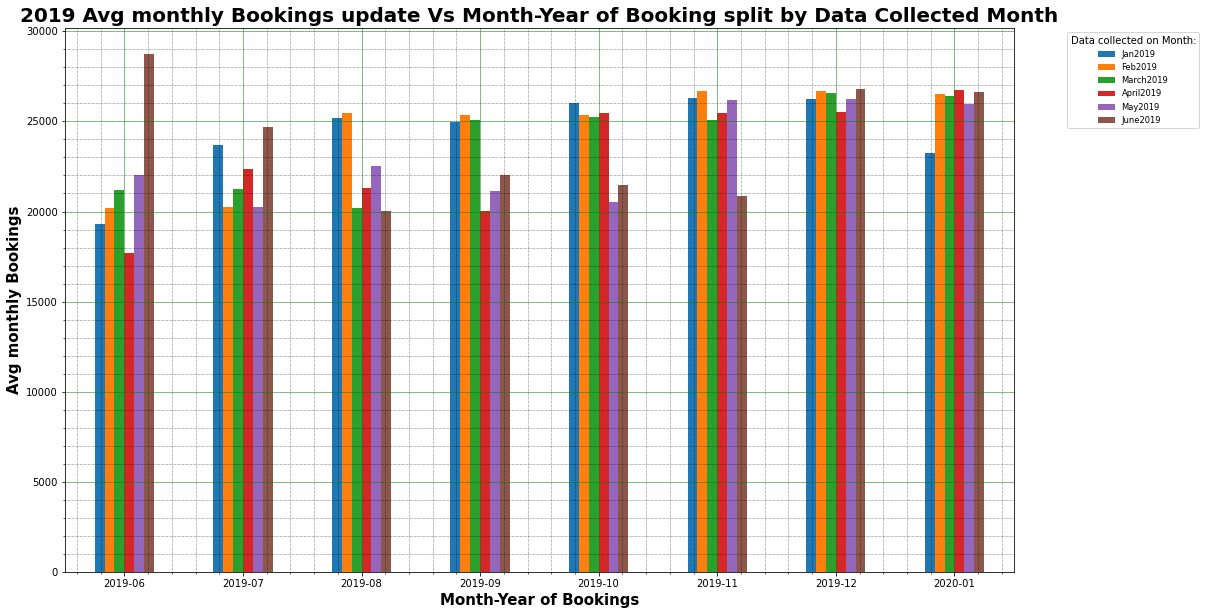

In [52]:
#Avg Daily bookings for month-year from data scraped/collected during the month of Jan to June 2019
cal2019_avgbookings.plot(kind='bar',figsize=(17,10)).legend(bbox_to_anchor=(1.2, 1),loc="upper right",title="Data collected on Month:", fontsize='small', fancybox=True)

# Turn on the grid
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.title('2019 Avg monthly Bookings update Vs Month-Year of Booking split by Data Collected Month',fontsize =20,fontweight = 'bold')
plt.xlabel("Month-Year of Bookings",fontsize =15,fontweight = 'bold')
plt.ylabel("Avg monthly Bookings",fontsize =15,fontweight = 'bold')
plt.xticks(rotation=0)
plt.show()


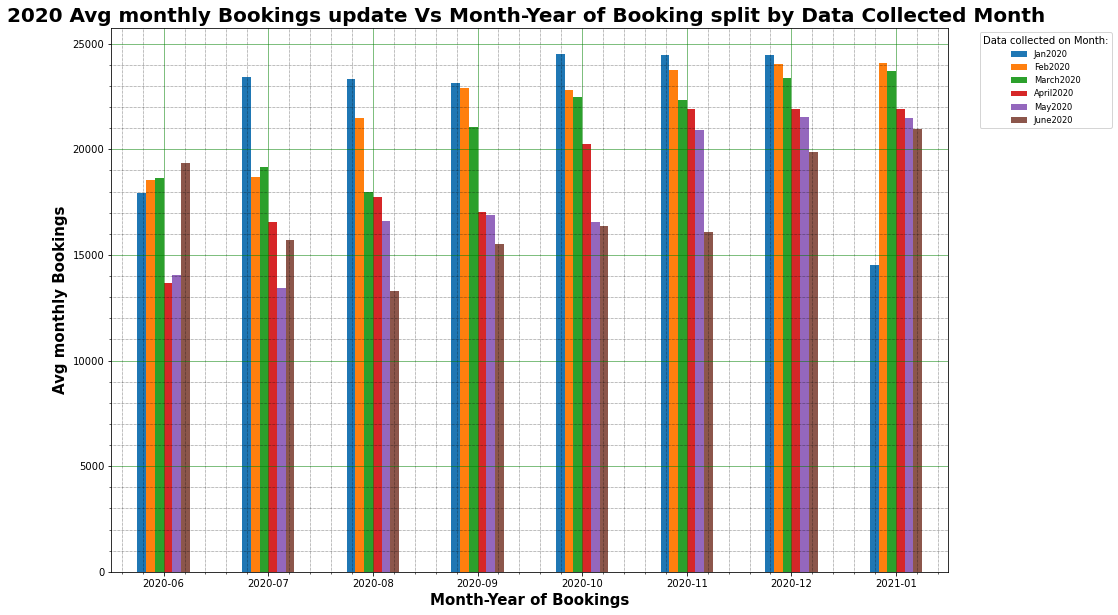

In [53]:
#Avg Daily bookings for month-year from data scraped/collected during the month of Jan to June 2019
cal2020_avgbookings.plot(kind='bar',figsize=(15,10)).legend(bbox_to_anchor=(1.2, 1),loc="upper right",title="Data collected on Month:", fontsize='small', fancybox=True)

# Turn on the grid
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.title('2020 Avg monthly Bookings update Vs Month-Year of Booking split by Data Collected Month ',fontsize =20,fontweight = 'bold')
plt.xlabel("Month-Year of Bookings",fontsize =15,fontweight = 'bold')
plt.ylabel("Avg monthly Bookings",fontsize =15,fontweight = 'bold')
plt.xticks(rotation=0)
plt.show()


From the generic trends it is visible that in 2019 there isnt a standard trend with Total bookings going higher or lower closer to the booking date it may even depend on seasonality of bookings. However, during 2020 we can see that in general bookings dropped/cancellations increased closer to the booking date(that is dataset collected in May2020 and June 2020) which could  be the impact of lockdowns that were announced during covid in Los Angeles   

**Next we can check the average difference in Daily bookings in a month across all the datasets in 2019 vs 2020**

In [54]:
#generating dataset with  Bookings per day in a particular month  Avgeraged across all datasets
avgbookings=cal2019_avgbookings.mean(axis=1).to_frame(name='2019avg_bookings').reset_index()

avgbookings['month_year']=avgbookings['month_year'].dt.month.apply(lambda x: calendar.month_abbr[x])
avgbookings.rename(columns = {'month_year':'Month'}, inplace = True) 

avgbookings['2020avg_bookings']=cal2020_avgbookings.mean(axis=1).to_frame(name='2020avg_bookings').reset_index(drop=True)['2020avg_bookings']
avgbookings['Diff_in_Avgperday_booking']=avgbookings['2019avg_bookings']-avgbookings['2020avg_bookings']
avgbookings.head()

,Month,2019avg_bookings,2020avg_bookings,Diff_in_Avgperday_booking
0,Jun,21526.444444,17031.293651,4495.150794
1,Jul,22085.784946,17834.258065,4251.526882
2,Aug,22451.752688,18411.774194,4039.978495
3,Sep,23091.938889,19422.883333,3669.055556
4,Oct,24010.575269,20489.494624,3521.080645


In [55]:
#generating dataset with month wise avg sales per Day in 2019 and 2020
avgsales=cal2019_avgsales.mean(axis=1).to_frame(name='2019avg_sales').reset_index()

avgsales['month_year']=avgsales['month_year'].dt.month.apply(lambda x: calendar.month_abbr[x])
avgsales.rename(columns = {'month_year':'Month'}, inplace = True) 

avgsales['2020avg_sales']=cal2020_avgsales.mean(axis=1).to_frame(name='2020avg_sales').reset_index(drop=True)['2020avg_sales']
avgsales['Diff_in_Avgperday_sales']=avgsales['2019avg_sales']-avgsales['2020avg_sales']
display(avgsales.head())

,Month,2019avg_sales,2020avg_sales,Diff_in_Avgperday_sales
0,Jun,351468742552.037048,333541917447.714294,17926825104.322754
1,Jul,350280073159.844055,331366115608.112854,18913957551.731201
2,Aug,357571610947.333313,352468161965.215027,5103448982.118286
3,Sep,378369571190.116699,385900921157.811096,-7531349967.694397
4,Oct,397673649513.026855,412267285591.247314,-14593636078.220459


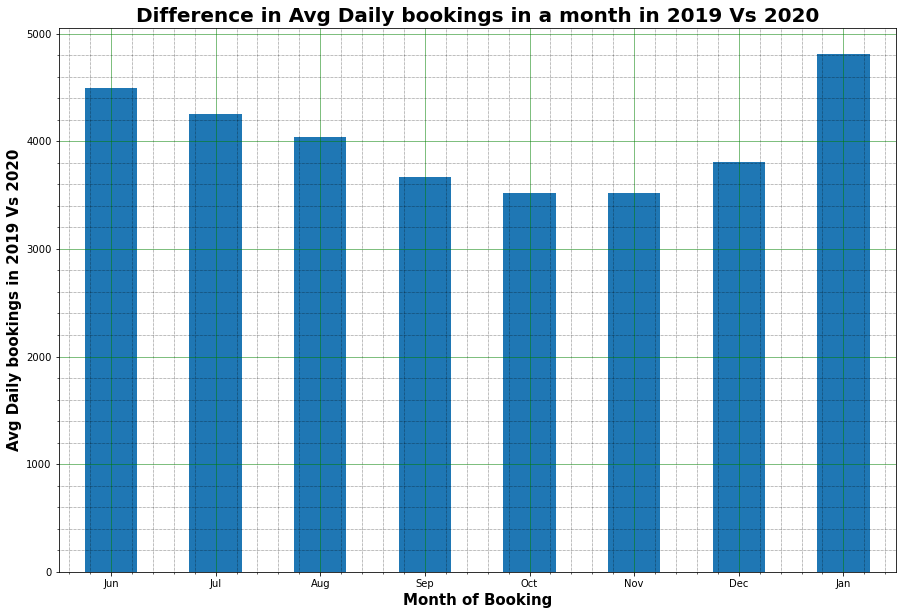

In [142]:
#Plotting the delta between avg Daily bookings in a month in 2019 vs 2020
# Turn on the grid
avgbookings.plot(x="Month", y=["Diff_in_Avgperday_booking"],kind='bar',figsize=(15,10),legend=False)
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.title('Difference in Avg Daily bookings in a month in 2019 Vs 2020',fontsize =20,fontweight = 'bold')
plt.xlabel("Month of Booking",fontsize =15,fontweight = 'bold')
plt.ylabel("Avg Daily bookings in 2019 Vs 2020",fontsize =15,fontweight = 'bold')
plt.xticks(rotation=0)
plt.show()

The above difference/delta chart shows that in general average bookings per day have dropped by 3500 to 5000 per Day in 2020 when data was averaged for datasets collected on Jan to June at the beginning of 2019 and 2020.

**Clarification:** The June to Jan months depicted in the graph above are the actual months of bookings and not the month when data was collected on.The Jan bar is for the next year i.e in 2019 dataset it indicates Jan-2020 bookings diff and in 2020 datatset it indicates Jan-2021. Similar logic is used for the below graph as well.

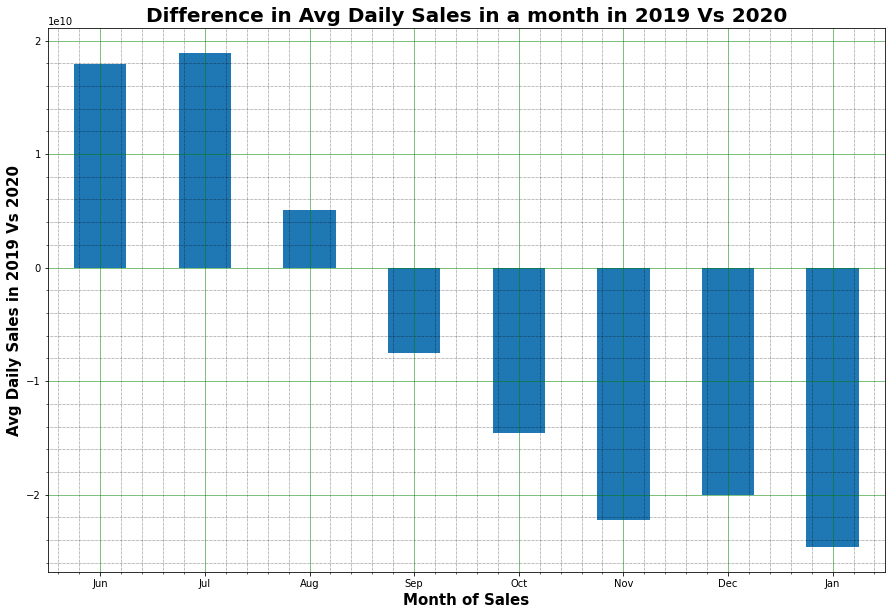

In [56]:
#Plotting the delta between avg Daily sales in a month in 2019 vs 2020
# Turn on the grid
avgsales.plot(x="Month", y=["Diff_in_Avgperday_sales"],kind='bar',figsize=(15,10),legend=False)
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.title('Difference in Avg Daily Sales in a month in 2019 Vs 2020',fontsize =20,fontweight = 'bold')
plt.xlabel("Month of Sales",fontsize =15,fontweight = 'bold')
plt.ylabel("Avg Daily Sales in 2019 Vs 2020",fontsize =15,fontweight = 'bold')
plt.xticks(rotation=0)
plt.show()

From the above charts an interesting observation that can be seen is that although overall bookings seem to have gone down ,based on current bookings average sales for advanced bookings in the next year are still higher in 2020 vs 2019, an interesting analysis would be to identify the features affecting bookings in 2019 vs 2020 which will be explored in Part-2 of the analysis